توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [3]:
#my_function
def normal(img):

    h, w = img.shape[:2]
    scale_factor = max(317/w, 317/h)
    img = cv2.resize(img, (round(scale_factor * w), round(scale_factor * h)))
    h, w = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    img = img[cY - 112:cY + 112, cX - 112:cX + 112]

    return img

# function 1
def displacement(img):

    h, w = img.shape[:2]
    scale_factor = max(317/w, 317/h)
    img = cv2.resize(img, (round(scale_factor * w), round(scale_factor * h)))

    h, w = img.shape[:2]

    (cX, cY) = (w // 2, h // 2)

    offset_h = random.randint(10, cY-112) * (-1)**random.randint(0, 1)
    offset_w = random.randint(10, cX-112) * (-1)**random.randint(0, 1)

    img = img[cY - 112 + offset_h:cY + 112 + offset_h, cX - 112 + offset_w:cX + 112 + offset_w]

    return img

# function 2
def rotation(img):

    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    theta = random.choice([random.gauss(0.35, 0.12), random.gauss(-0.35, 0.12)])
    a = max(h/w, w/h)

    factor = np.cos(theta) + np.abs(a * np.sin(theta))
    M = cv2.getRotationMatrix2D((cX, cY), theta * 180 / np.pi, factor)
    img = cv2.warpAffine(img, M, (w, h))

    return img


# function 3
def scaling(img):
    ## To Do
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    factor = random.expovariate(2)+0.5 # experimental
    M = np.array([[factor+1, 0, np.ceil(-factor*cX)],[0, factor+1, np.ceil(-factor*cY)]])
    img = cv2.warpAffine(img, M, (w, h))

    return img




# function 4
def Brightness(img):  ## for augmentation
    brightness = randint(0, 40)
    brightener = np.ones_like(img) * brightness
    clip_offset = 255 - img
    if randint(0, 1):
        brightener = (brightener < clip_offset) * brightener + (brightener >= clip_offset) * clip_offset
        img += brightener
    else:
        brightener = (brightener < img) * brightener
        img -= brightener

    return img



# function 5
def bluring(img):
    return cv2.GaussianBlur(img, (5, 5), 10)

# function 6
def gaussian_noise(img): #for augmentation

    noise = np.random.randn(*img.shape) * random.random()*40
    img = np.clip(img + noise, 0, 255).astype(np.uint8)

    return img

In [26]:
class CustomDataset(Dataset):
    def __init__(self, root, scene_file, transform=None, state='tr', aug=False): # state stands for tr: train, va: validation, te: test

        self.root = root
        self.transform = transform
        self.state = state
        self.aug = aug
        # Read scene file
        with open(scene_file, 'r') as file:

            lines = file.readlines()
            if state != 'te':
                self.filenames = [line.strip().split()[0]+".jpg" for line in lines if line[4:6]==state]
            else :
                self.filenames = [line.strip() for line in lines if line[4:6]==state]

        # each one 2 times once without reshape once with reshape
        self.labels = [[randint(0, 1), randint(0, 1), randint(0, 1)] for i in range(len(self.filenames))]



    def __getitem__(self, idx):
        filename = self.filenames[idx]

        img_path = os.path.join(self.root, filename)  # Update path accordingly
        image = cv2.cvtColor(IM(img_path), cv2.COLOR_BGR2RGB)

        label = self.labels[idx]

        if self.aug:
            a = random.randint(0, 3)
            if a == 3 :
                image = Brightness(image)
            elif a == 2:
                image = bluring(image)
            elif a == 1:
                image = gaussian_noise(image)
        
        image2 = image.copy()
        image = normal(image)

        if label[0] == 1:
            image2 = rotation(image2)

        if label[1] == 1:
            image2 = scaling(image2)

        if label[2] == 1:
            image2 = displacement(image2)
        else:
            image2 = normal(image2)


        if self.transform:
            image = self.transform(image)
            image2 = self.transform(image2)

        return image, image2, torch.tensor(label)


    def __len__(self):
        return len(self.filenames)



In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 32

dataset_train = CustomDataset('ADEChallengeData2016/images/training/', 'ADEChallengeData2016/sceneCategories.txt', state='tr', transform=transform)## To Do
dataset_test = CustomDataset('release_test/testing/', 'release_test/list.txt', state='te', transform=transform)## To Do
dataset_val = CustomDataset('ADEChallengeData2016/images/validation/', 'ADEChallengeData2016/sceneCategories.txt', state='va', transform=transform)## To Do


train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)## To Do
test_loader= DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True)## To Do
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True)## To Do


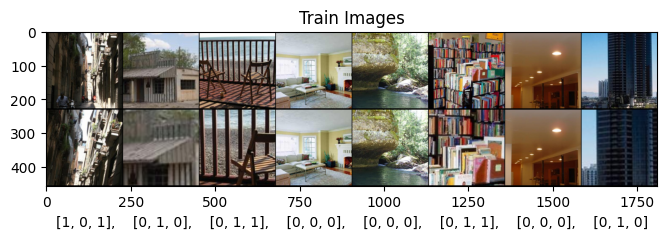

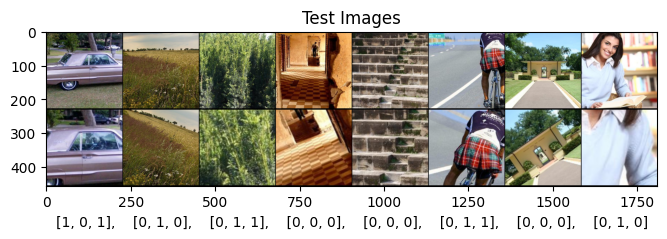

In [6]:
# To Do  : show 8 images from train_loader & 8 images from test_loader

import torchvision.utils as vutils

iter_train = next(iter(train_loader))
iter_test = next(iter(test_loader))

random_idx = random.sample(range(batch_size), 8)

image_grid_train = vutils.make_grid(iter_train[0][random_idx], padding=2, normalize=True)
image_grid_train = torch.cat([image_grid_train, vutils.make_grid(iter_train[1][random_idx], padding=2, normalize=True)], dim=1)
image_grid_test = vutils.make_grid(iter_test[0][random_idx], padding=2, normalize=True)
image_grid_test = torch.cat([image_grid_test, vutils.make_grid(iter_test[1][random_idx], padding=2, normalize=True)], dim=1)

plt.figure(figsize=(16,2))
plt.imshow(image_grid_train.permute(1, 2, 0))
plt.title('Train Images')

plt.xlabel(',    '.join([str(x.tolist()) for x in iter_train[2][random_idx]]))
plt.show()

plt.figure(figsize=(16,2))
plt.imshow(image_grid_test.permute(1, 2, 0))
plt.title('Test Images')
plt.xlabel(',    '.join([str(x.tolist()) for x in iter_train[2][random_idx]]))
plt.show()


##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

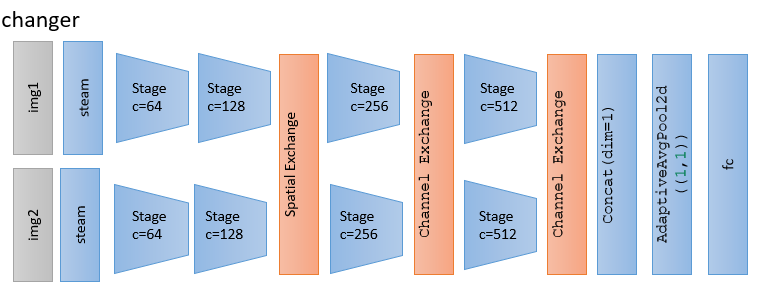

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


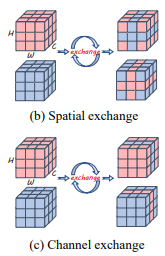

In [7]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

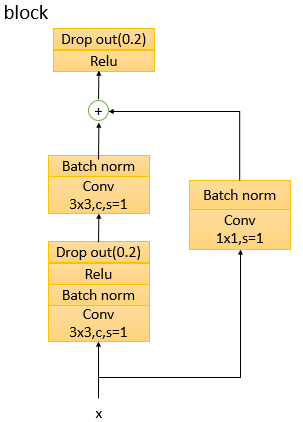

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





In [8]:
##To Do
class block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(block,self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        # Second block
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels)
        )

        # Output block
        self.output_block = nn.Sequential(
            nn.ReLU(),
            nn.Dropout2d(0.2)
        )

    def forward(self,x):
        return self.output_block(self.block1(x) + self.block2(x))



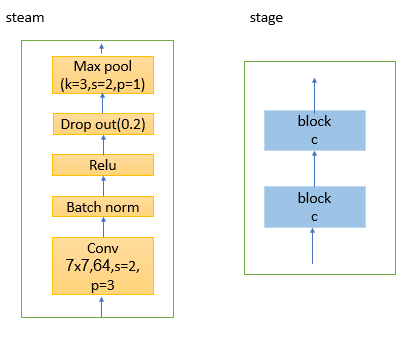

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [9]:
#To Do
class changer(nn.Module):
    def __init__(self,block,SpatialExchange,ChannelExchange):
        super(changer,self).__init__()

        self.steam = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Dropout2d(0.2),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )


        self.block = block

        self.stage1 = self._make_stage(64, 64)
        self.stage2 = self._make_stage(64, 128)
        self.stage3 = self._make_stage(128, 256)
        self.stage4 = self._make_stage(256, 512)


        self.SpatialExchange = SpatialExchange()
        self.ChannelExchange1 = ChannelExchange()
        self.ChannelExchange2 = ChannelExchange()

        self.adaptivePool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1024, 3, bias=True)

    def _make_stage(self, i, o):

        layers=[self.block(i, o), self.block(o, o)]

        return nn.Sequential(*layers)




    def forward(self,x1,x2):

        x1 = self.steam(x1)
        x1 = self.stage1(x1)
        x1 = self.stage2(x1)

        x2 = self.steam(x2)
        x2 = self.stage1(x2)
        x2 = self.stage2(x2)

        x1, x2 = self.SpatialExchange(x1, x2)
        x1 = self.stage3(x1)
        x2 = self.stage3(x2)

        x1, x2 = self.ChannelExchange1(x1, x2)
        x1 = self.stage4(x1)
        x2 = self.stage4(x2)


        x1, x2 = self.ChannelExchange2(x1, x2)
        out = self.adaptivePool(torch.cat((x1, x2), dim=1))
        out = torch.flatten(out, start_dim=1)
        out = self.fc(out)
        return out

In [10]:
## To Do
device = "cuda" if torch.cuda.is_available() else "cpu"


model=changer(block,SpatialExchange,ChannelExchange).to(device)

citeration = torch.nn.MSELoss()
optimizer= optim.Adam(model.parameters())

##Train & validation


In [22]:
Loss_train = []
Loss_val = []
num_epochs = 1

for epoch in range(num_epochs):
    model.train()

    # Training
    sum_loss_train = 0.0
    correct_train = 0
    total_train = 0

    for img1, img2, labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(img1, img2)
        predicted = (outputs > 0.5).int()

        loss = citeration(outputs, labels.float())
        loss.backward()
        optimizer.step()

        sum_loss_train += loss.item() / len(train_loader)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum(dim=0).float().mean().item()

    num_correct_train = round(correct_train / total_train * 100)

    # Validation
    model.eval()
    sum_loss_val = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for img1_val, img2_val, labels_val in val_loader:
            img1_val, img2_val, labels_val = img1_val.to(device), img2_val.to(device), labels_val.to(device)

            outputs_val = model(img1_val, img2_val)
            predicted_val = (outputs_val > 0.5).int()

            loss_val = citeration(outputs_val, labels_val.float())
            sum_loss_val += loss_val.item() / len(val_loader)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum(dim=0).float().mean().item()


    num_correct_val = round(correct_val / total_val * 100)

    print(f'Epoch [{epoch + 1}/{num_epochs}]'
          f' Loss_train: {sum_loss_train:.3f} Acc_train: {num_correct_train}%'
          f' Loss_val: {sum_loss_val:.3f} Acc_val: {num_correct_val}%')

    Loss_train.append(sum_loss_train)
    Loss_val.append(sum_loss_val)

    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': sum_loss_val  # Save validation loss instead of training loss
    }

    torch.save(checkpoint, f'model_checkpoint{epoch + 1}.pth')


Epoch [1/1] Loss_train: 0.217 Acc_train: 62% Loss_val: 0.210 Acc_val: 64%


#Test


In [23]:
checkpoint = torch.load('model_checkpoint3.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# ## To Do test

model.eval()
sum_loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for img1_test, img2_test, labels_test in test_loader:
            img1_test, img2_test, labels_test = img1_test.to(device), img2_test.to(device), labels_test.to(device)

            outputs_test = model(img1_test, img2_test)
            predicted_test = (outputs_test > 0.5).int()

            loss_test = citeration(outputs_test, labels_test.float())
            sum_loss_test += loss_test.item() / len(test_loader)
            total_test += labels_test.size(0)
            correct_test += (predicted_test == labels_test).sum(dim=0).float().mean().item()

    num_correct_test = round(correct_test / total_test * 100)


print(f' loss_test= {sum_loss_test:.3f}, acc_test={(num_correct_test)}%')


 loss_test= 0.213, acc_test=63%


## Adding data augmentation

In [27]:
transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 32

dataset_train = CustomDataset('ADEChallengeData2016/images/training/', 'ADEChallengeData2016/sceneCategories.txt', state='tr', transform=transform, aug=True)## To Do

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)## To Do



In [28]:
Loss_train = []
Loss_val = []
num_epochs = 2

for epoch in range(3, 3 + num_epochs):
    model.train()

    # Training
    sum_loss_train = 0.0
    correct_train = 0
    total_train = 0

    for img1, img2, labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(img1, img2)
        predicted = (outputs > 0.5).int()

        loss = citeration(outputs, labels.float())
        loss.backward()
        optimizer.step()

        sum_loss_train += loss.item() / len(train_loader)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum(dim=0).float().mean().item()

    num_correct_train = round(correct_train / total_train * 100)

    # Validation
    model.eval()
    sum_loss_val = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for img1_val, img2_val, labels_val in val_loader:
            img1_val, img2_val, labels_val = img1_val.to(device), img2_val.to(device), labels_val.to(device)

            outputs_val = model(img1_val, img2_val)
            predicted_val = (outputs_val > 0.5).int()

            loss_val = citeration(outputs_val, labels_val.float())
            sum_loss_val += loss_val.item() / len(val_loader)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum(dim=0).float().mean().item()


    num_correct_val = round(correct_val / total_val * 100)

    print(f'Epoch [{epoch + 1}/{num_epochs}]'
          f' Loss_train: {sum_loss_train:.3f} Acc_train: {num_correct_train}%'
          f' Loss_val: {sum_loss_val:.3f} Acc_val: {num_correct_val}%')

    Loss_train.append(sum_loss_train)
    Loss_val.append(sum_loss_val)

    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': sum_loss_val  # Save validation loss instead of training loss
    }

    torch.save(checkpoint, f'model_checkpoint{epoch + 1}.pth')


Epoch [4/2] Loss_train: 0.223 Acc_train: 61% Loss_val: 0.212 Acc_val: 64%
Epoch [5/2] Loss_train: 0.218 Acc_train: 62% Loss_val: 0.210 Acc_val: 63%


In [30]:
checkpoint = torch.load('model_checkpoint5.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## To Do test

model.eval()
sum_loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for img1_test, img2_test, labels_test in test_loader:
            img1_test, img2_test, labels_test = img1_test.to(device), img2_test.to(device), labels_test.to(device)

            outputs_test = model(img1_test, img2_test)
            predicted_test = (outputs_test > 0.5).int()

            loss_test = citeration(outputs_test, labels_test.float())
            sum_loss_test += loss_test.item() / len(test_loader)
            total_test += labels_test.size(0)
            correct_test += (predicted_test == labels_test).sum(dim=0).float().mean().item()

    num_correct_test = round(correct_test / total_test * 100)


print(f' loss_test= {sum_loss_test:.3f}, acc_test={(num_correct_test)}%')

 loss_test= 0.214, acc_test=63%


همان طور که دیده شد تغییر فاحشی پس از انجام آگمنتیشن در دقت مشاهده نمیشود این به این خاطر است که دیتاست به قدر کافی جامع و بزرگ است

سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟